In [38]:
# Import necessary packages
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 
import numpy as np 
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

In [2]:
# Load the data and print the first rows
data = pd.read_csv('../data/data.csv')
data.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [3]:
# Get info about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [4]:
# Check how many companies are bankrupt
print(data['Bankrupt?'].value_counts())

0    6599
1     220
Name: Bankrupt?, dtype: int64


#### Here, we have three solutions to address this imbalanced dataset. First one is, undersampling the majority class which in this case financially sound companies. This would result in a very small set at the final that is not suitable for an ML task. The second one is oversampling the minority class. That would work however creates an extra step which I think unnecessary at this point. The third one and my choice is leaving it imbalanced. This makes sence since I am planning to use XGBoost and it has a parameter to address this problem easily.

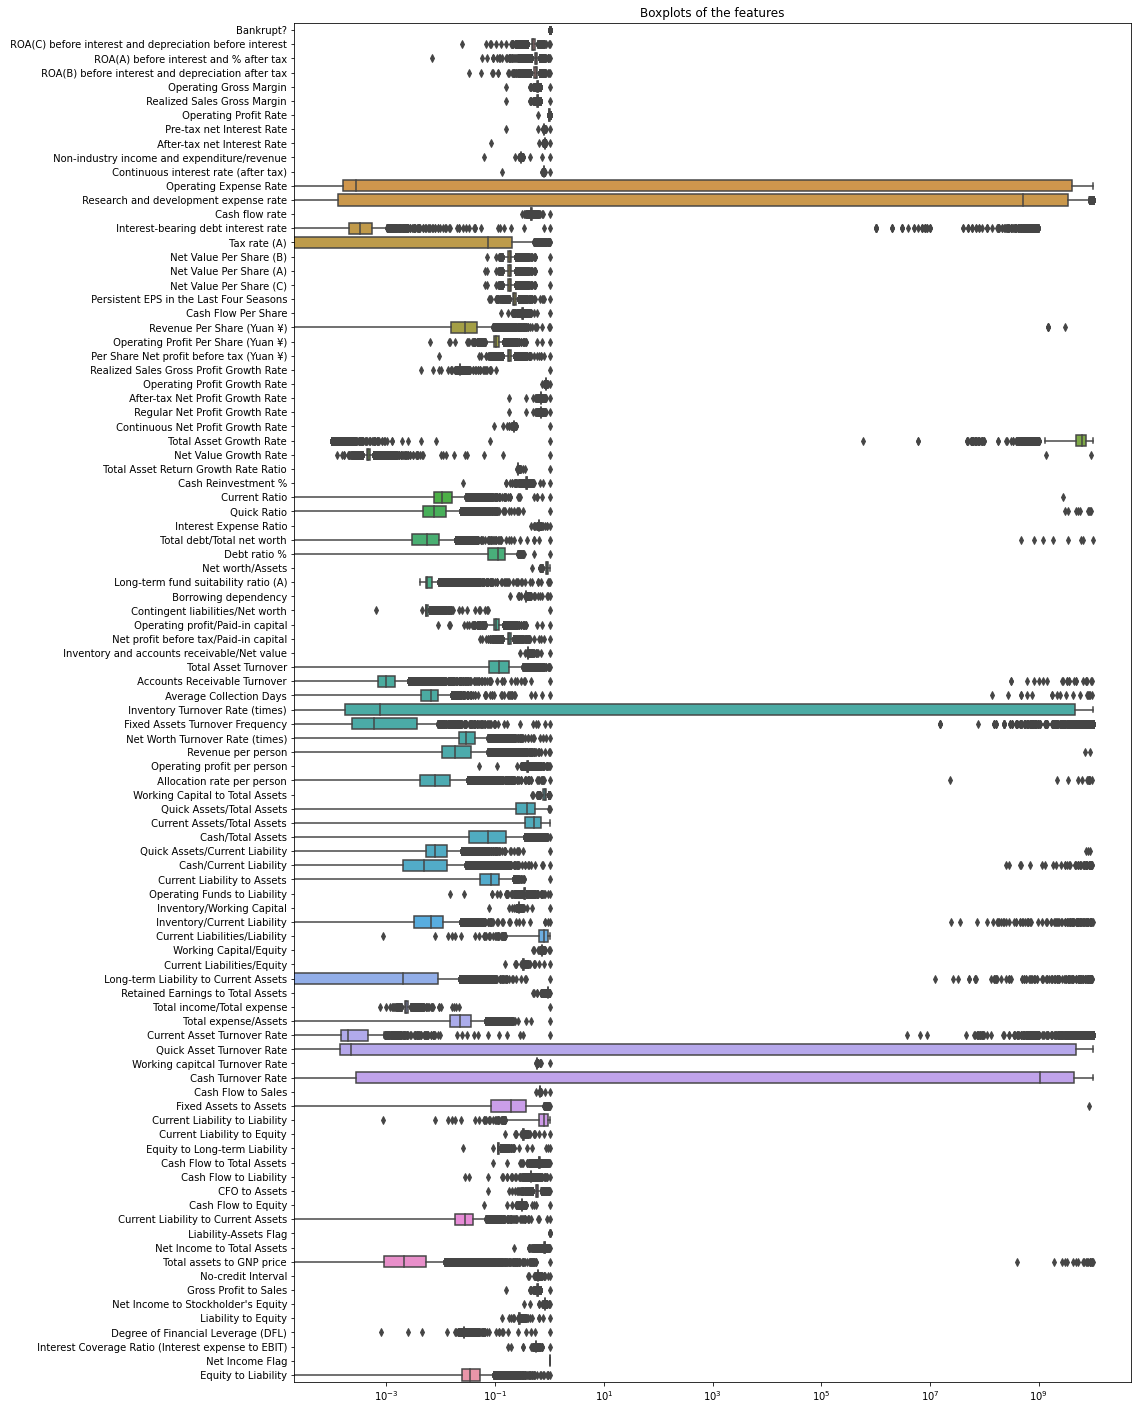

In [5]:
# Create boxplots to see features more detailed.

plt.figure(figsize= (15, 25))
ax = sns.boxplot(data = data, orient='h')
ax.set(xscale='log')
ax.set_title('Boxplots of the features')
plt.show()

#### It seems some of our features are skewed and contain outliers. This is pretty normal since we are actually working with financial ratios. The black dots are outliers because they are either greater than upper whisker or smaller than lower whisker. We can remove or impute them. Removing them would be loss of information, eventhough they are outliers. Imputing them with appropriate values would result better. 

In [6]:
# Find the interesting columns with outliers.
data.columns[data.max() > 1.0]

Index([' Operating Expense Rate', ' Research and development expense rate',
       ' Interest-bearing debt interest rate', ' Revenue Per Share (Yuan ¥)',
       ' Total Asset Growth Rate', ' Net Value Growth Rate', ' Current Ratio',
       ' Quick Ratio', ' Total debt/Total net worth',
       ' Accounts Receivable Turnover', ' Average Collection Days',
       ' Inventory Turnover Rate (times)', ' Fixed Assets Turnover Frequency',
       ' Revenue per person', ' Allocation rate per person',
       ' Quick Assets/Current Liability', ' Cash/Current Liability',
       ' Inventory/Current Liability',
       ' Long-term Liability to Current Assets',
       ' Current Asset Turnover Rate', ' Quick Asset Turnover Rate',
       ' Cash Turnover Rate', ' Fixed Assets to Assets',
       ' Total assets to GNP price'],
      dtype='object')

In [7]:
# For backup
original_data = data.copy()

In [8]:
# Save labels and drop them from the data.
labels = data['Bankrupt?']
data.drop('Bankrupt?', axis=1, inplace=True)

#### Before working on outliers we need to split our data to prevent data leakage. Test set is unseen data and it should remain in that way.

In [11]:
# Train - Test split.
X_train, X_test, y_train, y_test = train_test_split(data,
                                                   labels,
                                                   test_size=0.1,
                                                   stratify=labels,
                                                   random_state=42)

#### My preferred method for this time is imputing extreme values with the value at certain percentiles. Do this step on training data and save max and min values to use for the test set. The test set has not been included into process of calculating the max and min values.

In [12]:
def winsorise_data(data):
    cutoff_log = {}
    for col in list(data.columns):
        if col not in [' Liability-Assets Flag', ' Net Income Flag']:
            temp = data[col].copy()
            data[col] = winsorize(temp, limits=[0.05, 0.05])
            col_max = data[col].max()
            col_min = data[col].min()
            cutoff_log[col] = (col_min, col_max)
    return cutoff_log

In [13]:
cutoff = winsorise_data(X_train)

#### Using saved min and max values we should do imputations in the test set as well.

In [14]:
def winsorise_test(test_data, cutoff):
    for key in list(cutoff.keys()):
        temp = test_data[key].copy()
        min_val = cutoff[key][0]
        max_val = cutoff[key][1]
        upper_index = temp[temp > max_val].index
        lower_index = temp[temp < min_val].index
        temp.loc[upper_index] = max_val
        temp.loc[lower_index] = min_val
        test_data[key] = temp

In [15]:
winsorise_test(X_test, cutoff)

In [16]:
# Weighted XGBoost for Imbalanced Classification

#### I go with XGBoost, powerful method for tabular data. (XGBoost is all you need!!! (That's a joke. But also true...)).

#### To adress the imbalanced dataset, introduce scale_pos_weight parameter into model. Check documentation to see how it is calculated.

In [17]:
scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()  # From XGBoost Documentation

In [18]:
model = XGBClassifier(scale_pos_weight=scale_pos_weight)

#### Cross-Validation 

In [19]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

In [20]:
scores = cross_val_score(model, X_train, y_train,
                        scoring='roc_auc', cv=cv, n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   22.1s finished


In [21]:
print('Mean ROC AUC: %.5f' %np.mean(scores))

Mean ROC AUC: 0.93742


In [22]:
# OPTIMISATION PART 

#### Eventhough the base XGBoost model does a good job, there is still a room for improvement. Here, I use RandomizedSearchCV for a quick optimization step.

In [23]:
params = {
    'max_depth': [3, 6, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': np.arange(0.5, 1.0, 0.1),
    'n_estimators': [100, 150, 200, 300, 350],
}

In [29]:
opt_model = XGBClassifier(scale_pos_weight=scale_pos_weight)

In [30]:
clf = RandomizedSearchCV(estimator=opt_model,
                        param_distributions=params,
                        scoring='roc_auc',
                        n_iter=20,
                        n_jobs=-1,
                        verbose=2)

In [31]:
results = clf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/mehmetcan/Desktop/PythonProjects/cbp/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:18:25] WARNING: /private/var/folders/kx/gbcxjsq129zbvngqs1cljs780000gn/T/pip-install-mwq9s19w/xgboost_60710fb34cf7423eb88372d345286f85/build/temp.macosx-10.14.6-arm64-3.8/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [32]:
print('Best Score: %s' % results.best_score_)
print('Best Hyperparameters: %s' % results.best_params_)

Best Score: 0.938328878197946
Best Hyperparameters: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1}


In [34]:
# Train the optimised model and test it on test set

In [33]:
optimised_model = XGBClassifier(subsample=0.7,
                               n_estimators=200,
                               max_depth=10,
                               learning_rate=0.1,
                               scale_pos_weight=scale_pos_weight)

In [35]:
optimised_model.fit(X_train, y_train)

/Users/mehmetcan/Desktop/PythonProjects/cbp/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:21:19] WARNING: /private/var/folders/kx/gbcxjsq129zbvngqs1cljs780000gn/T/pip-install-mwq9s19w/xgboost_60710fb34cf7423eb88372d345286f85/build/temp.macosx-10.14.6-arm64-3.8/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=29.994949494949495,
              subsample=0.7, tree_method='exact', validate_parameters=1,
              verbosity=None)

/Users/mehmetcan/Desktop/PythonProjects/cbp/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehmetcan/Desktop/PythonProjects/cbp/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehmetcan/Desktop/PythonPro

[21:15:57] WARNING: /private/var/folders/kx/gbcxjsq129zbvngqs1cljs780000gn/T/pip-install-mwq9s19w/xgboost_60710fb34cf7423eb88372d345286f85/build/temp.macosx-10.14.6-arm64-3.8/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=15, n_estimators=350, subsample=0.6; total time=  16.8s
[21:16:14] WARNING: /private/var/folders/kx/gbcxjsq129zbvngqs1cljs780000gn/T/pip-install-mwq9s19w/xgboost_60710fb34cf7423eb88372d345286f85/build/temp.macosx-10.14.6-arm64-3.8/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.7; total 

/Users/mehmetcan/Desktop/PythonProjects/cbp/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehmetcan/Desktop/PythonProjects/cbp/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehmetcan/Desktop/PythonPro

[21:15:57] WARNING: /private/var/folders/kx/gbcxjsq129zbvngqs1cljs780000gn/T/pip-install-mwq9s19w/xgboost_60710fb34cf7423eb88372d345286f85/build/temp.macosx-10.14.6-arm64-3.8/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=6, n_estimators=150, subsample=0.6; total time=   6.7s
[21:16:04] WARNING: /private/var/folders/kx/gbcxjsq129zbvngqs1cljs780000gn/T/pip-install-mwq9s19w/xgboost_60710fb34cf7423eb88372d345286f85/build/temp.macosx-10.14.6-arm64-3.8/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=15, n_estimators=350, subsample=0.6; total t

/Users/mehmetcan/Desktop/PythonProjects/cbp/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehmetcan/Desktop/PythonProjects/cbp/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehmetcan/Desktop/PythonPro

[21:15:57] WARNING: /private/var/folders/kx/gbcxjsq129zbvngqs1cljs780000gn/T/pip-install-mwq9s19w/xgboost_60710fb34cf7423eb88372d345286f85/build/temp.macosx-10.14.6-arm64-3.8/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=15, n_estimators=350, subsample=0.6; total time=  17.1s
[21:16:14] WARNING: /private/var/folders/kx/gbcxjsq129zbvngqs1cljs780000gn/T/pip-install-mwq9s19w/xgboost_60710fb34cf7423eb88372d345286f85/build/temp.macosx-10.14.6-arm64-3.8/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.7; total 

/Users/mehmetcan/Desktop/PythonProjects/cbp/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehmetcan/Desktop/PythonProjects/cbp/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehmetcan/Desktop/PythonPro

[21:15:57] WARNING: /private/var/folders/kx/gbcxjsq129zbvngqs1cljs780000gn/T/pip-install-mwq9s19w/xgboost_60710fb34cf7423eb88372d345286f85/build/temp.macosx-10.14.6-arm64-3.8/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=6, n_estimators=150, subsample=0.6; total time=   6.8s
[21:16:04] WARNING: /private/var/folders/kx/gbcxjsq129zbvngqs1cljs780000gn/T/pip-install-mwq9s19w/xgboost_60710fb34cf7423eb88372d345286f85/build/temp.macosx-10.14.6-arm64-3.8/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=6, n_estimators=200, subsample=0.7; total ti

/Users/mehmetcan/Desktop/PythonProjects/cbp/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehmetcan/Desktop/PythonProjects/cbp/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehmetcan/Desktop/PythonPro

[21:15:57] WARNING: /private/var/folders/kx/gbcxjsq129zbvngqs1cljs780000gn/T/pip-install-mwq9s19w/xgboost_60710fb34cf7423eb88372d345286f85/build/temp.macosx-10.14.6-arm64-3.8/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=6, n_estimators=150, subsample=0.6; total time=   6.7s
[21:16:04] WARNING: /private/var/folders/kx/gbcxjsq129zbvngqs1cljs780000gn/T/pip-install-mwq9s19w/xgboost_60710fb34cf7423eb88372d345286f85/build/temp.macosx-10.14.6-arm64-3.8/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=15, n_estimators=350, subsample=0.6; total t

/Users/mehmetcan/Desktop/PythonProjects/cbp/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehmetcan/Desktop/PythonProjects/cbp/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehmetcan/Desktop/PythonPro

[21:15:57] WARNING: /private/var/folders/kx/gbcxjsq129zbvngqs1cljs780000gn/T/pip-install-mwq9s19w/xgboost_60710fb34cf7423eb88372d345286f85/build/temp.macosx-10.14.6-arm64-3.8/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=15, n_estimators=350, subsample=0.6; total time=  17.4s
[21:16:15] WARNING: /private/var/folders/kx/gbcxjsq129zbvngqs1cljs780000gn/T/pip-install-mwq9s19w/xgboost_60710fb34cf7423eb88372d345286f85/build/temp.macosx-10.14.6-arm64-3.8/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.7; total 

/Users/mehmetcan/Desktop/PythonProjects/cbp/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehmetcan/Desktop/PythonProjects/cbp/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehmetcan/Desktop/PythonPro

In [36]:
probs = optimised_model.predict_proba(X_test)

In [44]:
# Classification Report

In [61]:
threshold = 0.3

preds = [0 if prob < threshold else 1 for prob in probs[:, 1]]

In [62]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       660
           1       0.45      0.64      0.53        22

    accuracy                           0.96       682
   macro avg       0.72      0.81      0.75       682
weighted avg       0.97      0.96      0.97       682

